In [34]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps
import pyNuHepMC as nhm
import matplotlib.pyplot as plt
import scipy
import yaml

In [35]:
# Fetch the submission YAML
submission_path = "/root/software/NUISANCEMC/data/nu/MicroBooNE/Ar/numu/arxiv.2310.06082/testout"
submission = "submission.yaml"

data_files = {}

with open("/".join([submission_path, submission]), 'r') as file:
    submission_yaml = yaml.safe_load_all(file)
    for doc in submission_yaml:
        if "data_file" in doc:
            df = doc["data_file"]
            with open("/".join([submission_path, df]), 'r') as datafile:
                data_files[df] = yaml.safe_load(datafile)
                
print(data_files.keys())

dict_keys(['cross_section-pn.yaml', 'covariance-pn.yaml', 'smearing-pn.yaml', 'cross_section-alpha3d.yaml', 'covariance-alpha3d.yaml', 'smearing-alpha3d.yaml', 'cross_section-phi3d.yaml', 'covariance-phi3d.yaml', 'smearing-phi3d.yaml', 'cross_section-pn_para.yaml', 'covariance-pn_para.yaml', 'smearing-pn_para.yaml', 'cross_section-pn_perp.yaml', 'covariance-pn_perp.yaml', 'smearing-pn_perp.yaml', 'cross_section-pn_perp_x.yaml', 'covariance-pn_perp_x.yaml', 'smearing-pn_perp_x.yaml', 'cross_section-pn_perp_y.yaml', 'covariance-pn_perp_y.yaml', 'smearing-pn_perp_y.yaml'])


In [36]:
measurements = []

for var in ["pn","alpha3d","phi3d"]:
    meas = {}
    meas["doc"] = data_files["cross_section-%s.yaml" %var]
    meas["indep"] = [ kv["header"]["name"] for kv in meas["doc"]["independent_variables"] ]
    meas["quals"] = { kv["name"]:kv["value"] \
        for kv in meas["doc"]["dependent_variables"][0]["qualifiers"]}
    meas["smearing_doc"] = data_files["%s.yaml" % meas["quals"]["smearing"]]
    meas["smearing_mat"] = pn.convert.Covariance.from_yaml_str(str(meas["smearing_doc"]))
    
    print("Measurement: %s" % var)
    print("  Target: %s" % meas["quals"]["target"])
    print("  Probe Species: %s" % meas["quals"]["probe_species"])
    print("  Independent variables: %s" % meas["indep"])
    print("  Projection functions: %s" % \
          [ meas["quals"]["project:%s" % x] for x in meas["indep"] ])
    print("  Selection function: %s" %  meas["quals"]["select"])

    measurements.append(meas)

Measurement: pn
  Target: Ar
  Probe Species: numu
  Independent variables: ['pn']
  Projection functions: ['MicroBooNE_CC0Pi_GKI_nu_pn']
  Selection function: MicroBooNE_CC0Pi_GKI_nu_SelectSignal
Measurement: alpha3d
  Target: Ar
  Probe Species: numu
  Independent variables: ['alpha3d']
  Projection functions: ['MicroBooNE_CC0Pi_GKI_nu_alpha3d']
  Selection function: MicroBooNE_CC0Pi_GKI_nu_SelectSignal
Measurement: phi3d
  Target: Ar
  Probe Species: numu
  Independent variables: ['phi3d']
  Projection functions: ['MicroBooNE_CC0Pi_GKI_nu_phi3d']
  Selection function: MicroBooNE_CC0Pi_GKI_nu_SelectSignal


In [5]:
evs = pn.EventSource("prdgen/MicroBooNE.nuwro.eventsout.root")
if not evs:
    print("Error: failed to open input file")

# Cross Sections

In [6]:
#load the select/project functions
pps.load_file("/".join([submission_path, "../analysis.cxx"]))

True

In [7]:
fg = pn.EventFrameGen(evs).filter(pps.select.get(measurements[0]["quals"]["select"]))
fg.add_column("enu",pps.project.enu)
for m in measurements:
    vn = m["indep"][0]
    fg.add_column(vn,
        pps.project.get(m["quals"]["project:%s" % vn]))

fg.add_column("MicroBooNE_CC0Pi_nu_dpt",pps.project.get("MicroBooNE_CC0Pi_nu_dpt"))
fg.add_column("MicroBooNE_CC0Pi_nu_dphit",pps.project.get("MicroBooNE_CC0Pi_nu_dphit"))
fg.add_column("MicroBooNE_CC0Pi_nu_dat",pps.project.get("MicroBooNE_CC0Pi_nu_dat"))

In [8]:
ef = fg.firstArrow(int(1E6))

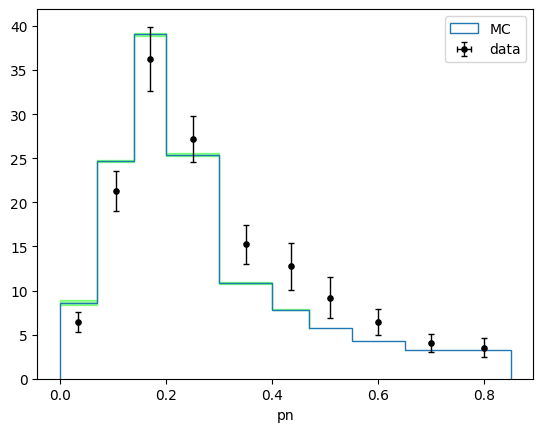

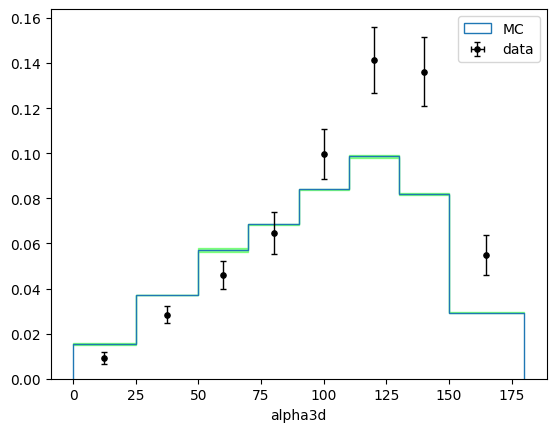

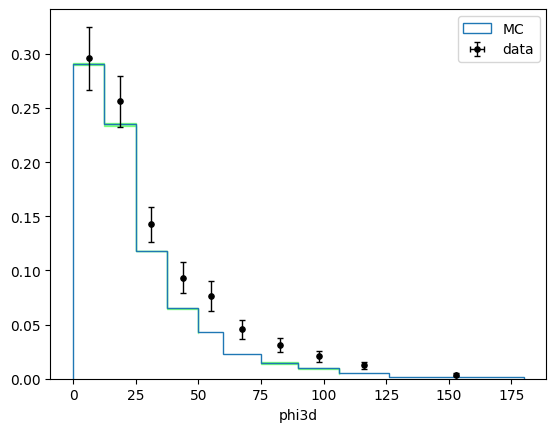

In [33]:
#fatx is in pb/A, -> 1pb is 10^-36 want /40 to take it back to the /N from the generator
sf = fg.norm_info().fatx_per_sumweights() * (1E2)

for m in measurements:
    m["datah"] = pn.convert.HistFrame.from_yaml_str(str(m["doc"]))
    m["mc"] = m["datah"].make_HistFrame()
    m["mc"].fill_procid_columns_from_Arrow(ef,[m["indep"][0]])

    #scale it to the right units and smear
    m["mc"].sumweights = np.matmul(m["smearing_mat"].transpose(),(m["mc"].sumweights * sf))
    m["mc"].variances = (m["smearing_mat"] @ m["smearing_mat"]) @ m["mc"].variances * (sf**2)

    
    #divides by bw
    m["mcfinal"] = m["mc"].finalise(True)

    m["mcfinal"].mpl().hist(histtype="step", label="MC", errorband_color="#0F06")
    m["datah"].mpl().errorbar(marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)
    plt.legend()
    plt.show()